In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
# Keyword extraction module
!pip install rake-nltk
from rake_nltk import Rake

In [3]:
steam_df = pd.read_csv("steam_data.csv")
steam_df["release_date"] = pd.to_datetime(steam_df["release_date"])
steam_df.head()

,name,steam_review_score,steam_total_positive,steam_total_negative,metacritic,rawg_rating,avg_playtime,price_initial,rawg_genres,rawg_tags,steam_genres,steam_categories,total_recommendations,release_date,short_description,required_age,esrb,recommendation_score,developers,steam_charts_data,all_time_peak_players,rawg_name,rawg_rating_counts,steam_id
0,StarPrey,7.0,11,0,NaN,0.0,0.0,299.0,"[{'id': 51, 'name': 'Indie', 'slug': 'indie'},...","[{'id': 116, 'name': '2.5D', 'slug': '25d', 'l...","Action, Indie",Single-player,NaN,2020-11-23,Fast-paced top-down physicsy space dogfighting...,0,NaN,NaN,Narayana Walters,"[{'month-cell left': 'Last 30 Days', 'right nu...",0.0,StarPrey,0.0,1467390
1,Cyberpunk SFX,7.0,10,2,NaN,0.0,0.0,1199.0,"[{'id': 51, 'name': 'Indie', 'slug': 'indie'},...","[{'id': 69, 'name': 'Action-Adventure', 'slug'...","Action, Adventure, Indie, Simulation, Early Ac...","Single-player, Steam Achievements, Steam Cloud",NaN,2020-11-29,What can be more spectacular than a girl armed...,0,NaN,NaN,CyberCry Creators,NaN,NaN,Cyberpunk SFX,0.0,1465260
2,Megacraft Hentai Edition,7.0,24,6,NaN,0.0,0.0,99.0,"[{'id': 3, 'name': 'Adventure', 'slug': 'adven...","[{'id': 134, 'name': 'Anime', 'slug': 'anime',...","Action, Adventure, Casual, Indie, RPG, Simulation",Single-player,NaN,2020-11-20,Megacraft Hentai Edition will allow you to sho...,0,NaN,NaN,Sweet Games,"[{'month-cell left': 'Last 30 Days', 'right nu...",7.0,Megacraft Hentai Edition,0.0,1464670
3,Ascent,8.0,62,1,NaN,0.0,0.0,499.0,"[{'id': 83, 'name': 'Platformer', 'slug': 'pla...","[{'id': 45, 'name': '2D', 'slug': '2d', 'langu...",Strategy,"Single-player, Steam Achievements",NaN,2020-11-20,One mountain; Zero checkpoints,0,NaN,NaN,Tim Kashani,"[{'month-cell left': 'Last 30 Days', 'right nu...",15.0,Ascent (itch),0.0,1464000
4,CAEDES,5.0,4,6,NaN,0.0,0.0,999.0,"[{'id': 5, 'name': 'RPG', 'slug': 'role-playin...","[{'id': 662, 'name': 'RPG Maker', 'slug': 'rpg...","Action, Indie, Simulation, Early Access",Single-player,NaN,2020-11-01,CAEDES is a merciless physics-based VR shooter...,0,NaN,NaN,Madar Games,"[{'month-cell left': 'Last 30 Days', 'right nu...",1.0,Caede's Pendant,0.0,1460510


## Top Keywords Among Best-Rated Games

In [ ]:
sub_df = pd.DataFrame(steam_df[["steam_total_positive", 
                                "steam_total_negative", 
                                "short_description"]])
sub_df["steam_positive_rate"] = sub_df["steam_total_positive"] / (sub_df["steam_total_positive"] + sub_df["steam_total_negative"])

keywords = {}
rake = Rake()

def extract_keyword(row):
    if row["steam_total_positive"] < 10000 and row["steam_positive_rate"] < 0.95:
        return
    descript = row["short_description"]
    rake.extract_keywords_from_text(descript)
    phrases = rake.get_ranked_phrases()
    for k in phrases:
        if k not in keywords:
            keywords[k] = 0
        keywords[k] += 1

sub_df.apply(extract_keyword, axis=1)

In [ ]:
# Clean the dataset by removing words that is featureless.
keywords.pop("game")
keywords.pop("play")
keywords.pop("way")
keywords.pop("quot")
keywords.pop("em")
keywords.pop("get")
keywords.pop("use")
keywords.pop("take")
keywords.pop("one")
keywords.pop("make")
keywords.pop("become")
keywords.pop("back")
keywords.pop("set")
keywords.pop("find")
keywords.pop("need")
keywords.pop("top")
keywords.pop("’")
keywords.pop("...")

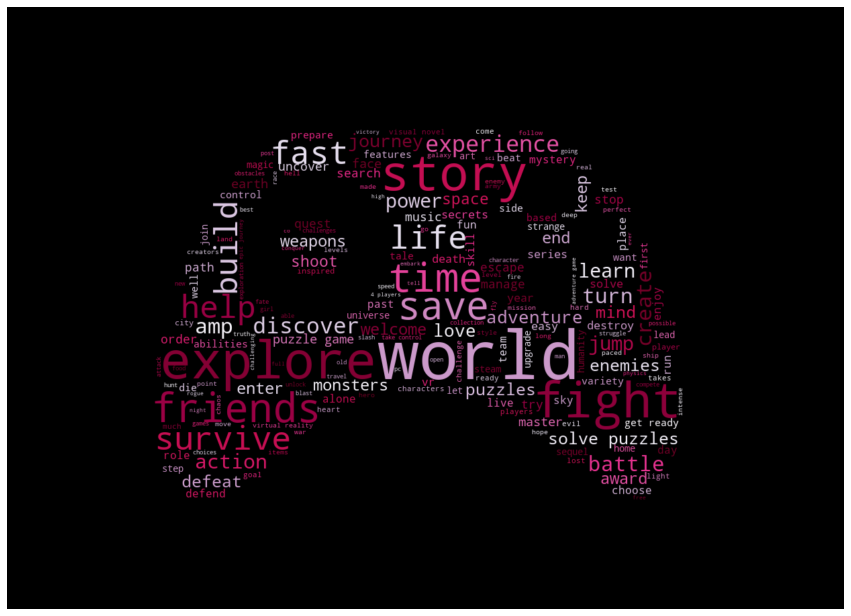

In [6]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
mask = np.array(Image.open('controller_mask.png'))

# Generate a word cloud of keywords.
wordcloud = WordCloud(max_font_size=100, 
                      max_words=200,
                      width=1000, 
                      height=1000,
                      background_color="Black",
                      random_state=5,
                      colormap='PuRd',
                      mask=mask,
                      ).generate_from_frequencies(keywords)
plt.figure(figsize=(15, 30))        
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
wordcloud.to_file("steam_wordcloud.png")
plt.show()

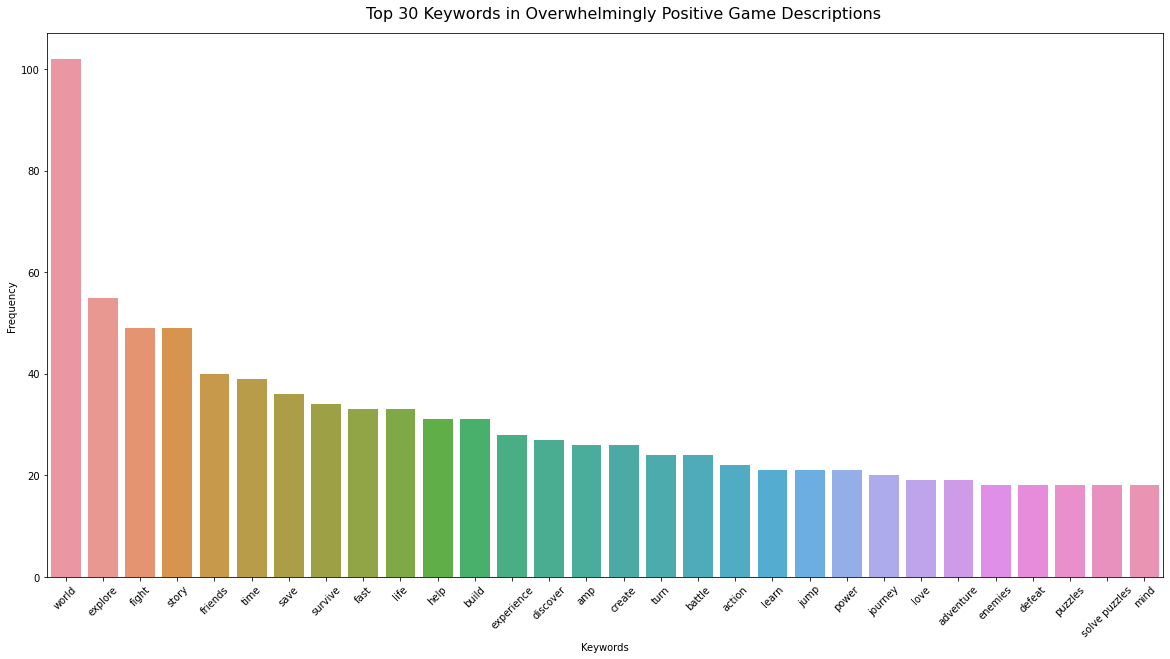

In [7]:
keywords_df = pd.DataFrame(keywords.items(), columns=["word", "frequency"])
keywords_df = keywords_df.sort_values(by="frequency", ascending=False)[:30]

plt.figure(figsize=(20, 10))
sns.barplot(data=keywords_df, x="word", y="frequency")
plt.xlabel("Keywords")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.text(15, 110,
         "Top 30 Keywords in Overwhelmingly Positive Game Descriptions",
         horizontalalignment='center',
         fontsize=16)
plt.savefig("keywords.png")
plt.show()

## The Genres that Players Love

In [ ]:
sub_df = pd.DataFrame(steam_df[["release_date",
                                "all_time_peak_players",
                                "steam_genres"]])
GAME_GENRES = ["Action", "Indie",  "Adventure", "Simulation", "Early Access", 
               "Casual", "RPG", "Strategy", "Sports", "Racing", 
               "Massively Multiplayer", "Violent", "Gore", "Nudity", 
               "Sexual Content"]

# The number of games of each genre from 2011 to 2020.
genre_df1 = pd.DataFrame(0, index=range(2011, 2021), columns=GAME_GENRES)

# The total number of peak time players of each genre gets from 2011 to 2020.
genre_df2 = pd.DataFrame(0, index=range(2011, 2021), columns=GAME_GENRES)

def fill_genre_df(row):
    year = row["release_date"].year
    if np.isnan(year) or year not in range(2011, 2021):
        return

    pk_players = row["all_time_peak_players"] if not np.isnan(row["all_time_peak_players"]) else 0
    genres = row["steam_genres"].split(", ")
    for genre in genres:
        if genre not in GAME_GENRES:
            continue
        genre_df1.loc[year, genre] += 1
        genre_df2.loc[year, genre] += pk_players

# Fill two genre dataframes.
sub_df.apply(fill_genre_df, axis=1)

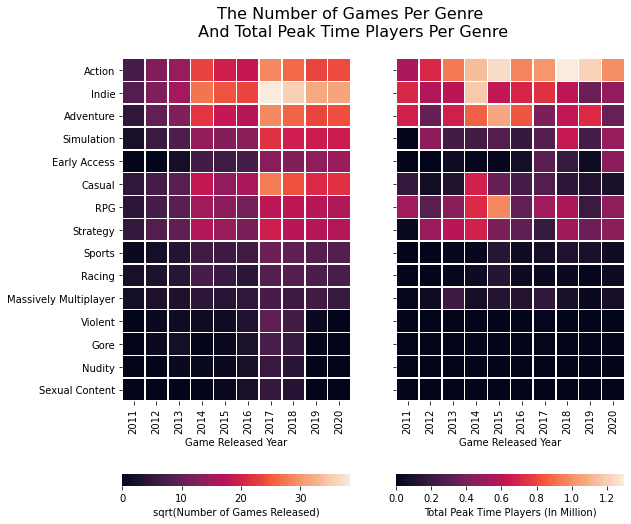

In [9]:
# Reduce the magnitude of the data to make visualization more intuitive.
reduced_genre_df1 = genre_df1.apply(np.sqrt)
reduced_genre_df2 = genre_df2 / 1000000

fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_figwidth(9)
fig.set_figheight(9)
sns.heatmap(reduced_genre_df1.transpose(), 
            linewidths=.5, 
            square=True,
            cbar_kws={"label": "sqrt(Number of Games Released)", 
                      "orientation": "horizontal"}, 
            ax=axes[0])
axes[0].set_xlabel("Game Released Year")
sns.heatmap(reduced_genre_df2.transpose(), 
            linewidths=.5, 
            square=True,
            cbar_kws={"label": "Total Peak Time Players (In Million)", 
                      "orientation": "horizontal"}, 
            ax=axes[1])
axes[1].set_xlabel("Game Released Year")
plt.text(-2, -1,
         "The Number of Games Per Genre\n And Total Peak Time Players Per Genre",
         horizontalalignment='center',
         fontsize=16)
fig.savefig("game_genre.png")
plt.show()

## Average Play Time Per Game Genre

In [ ]:
sub_df = pd.DataFrame(steam_df[["steam_genres", 
                                "avg_playtime", 
                                "steam_total_positive", 
                                "steam_total_negative"]])

GAME_GENRES = ["Action", "Indie",  "Adventure", "Simulation", 
               "Casual", "RPG", "Strategy"]

genre_time_df = pd.DataFrame(columns=["steam_genres", 
                                      "avg_playtime", 
                                      "overwhelmingly_pos"])

def fill_genre_time_df(row):
    avg_playtime = row["avg_playtime"] if row["avg_playtime"] < 20 else 20
    if avg_playtime <= 1:
        return

    pos = row["steam_total_positive"]
    neg = row["steam_total_negative"]
    overwhelmingly_pos = (pos >= 10000) and (pos / (pos + neg) >= 0.95)
    genres = row["steam_genres"].split(", ")
    for genre in genres:
        if genre not in GAME_GENRES:
            continue
        genre_time_df.loc[len(genre_time_df)] = [genre, avg_playtime, overwhelmingly_pos] 

sub_df.apply(fill_genre_time_df, axis=1)

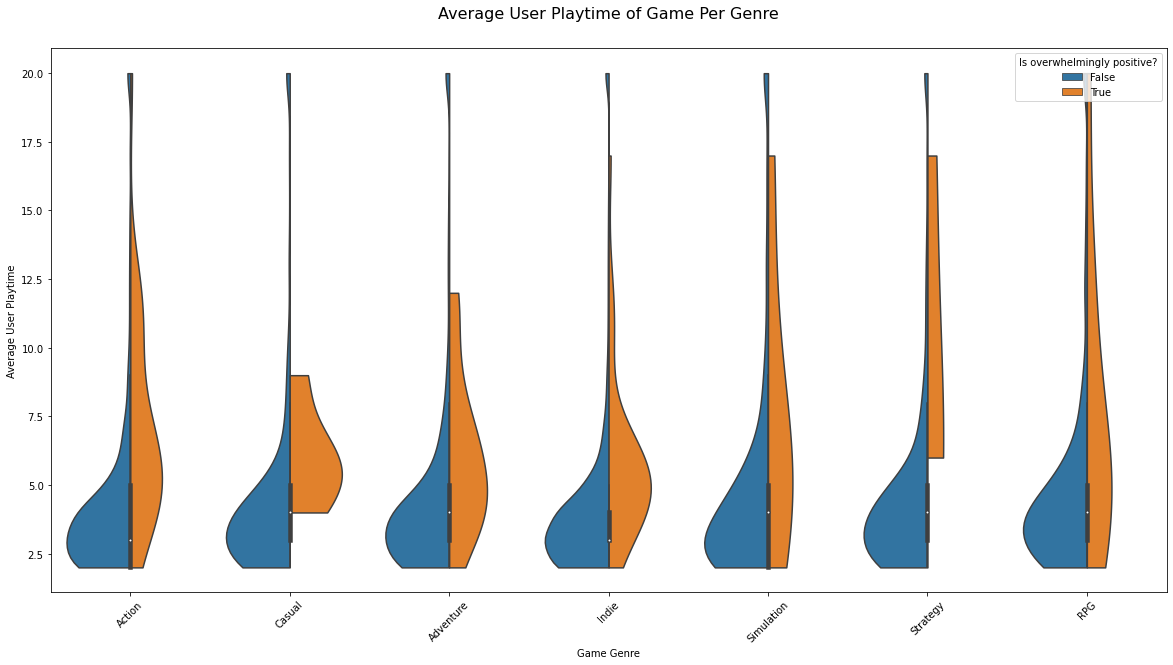

In [11]:
plt.figure(figsize=(20, 10))
genre_time_df.columns = ["Game Genre", 
                         "Average User Playtime", 
                         "Is overwhelmingly positive?"]
sns.violinplot(data=genre_time_df, x="Game Genre", y="Average User Playtime", 
               hue="Is overwhelmingly positive?", split=True,
               width=0.8, cut=0)
plt.text(3, 22,
         "Average User Playtime of Game Per Genre",
         horizontalalignment='center',
         fontsize=16)
plt.xticks(rotation=45)
plt.savefig("playtime.png")
plt.show()

## Game Price over Time

In [12]:
sub_df = pd.DataFrame(steam_df[["name",
                                "release_date",
                                "price_initial"]])
sub_df["release_date"] = sub_df["release_date"].apply(lambda date: pd.Period(date, freq='M'))
sub_df["price_initial"] = sub_df["price_initial"] / 100  # Set unit to be dollar.

months_to_be_removed = [pd.Period("1997-06"),
                        pd.Period("1997-11"),
                        pd.Period("2020-12")]

count_df = sub_df[["name", "release_date"]].groupby("release_date").agg(["count"])
count_df.columns = ["number_of_game_released"]
count_df.drop(months_to_be_removed, inplace=True)

price_df = sub_df[["release_date", "price_initial"]].groupby("release_date").agg("mean")
price_df.drop(months_to_be_removed, inplace=True) 

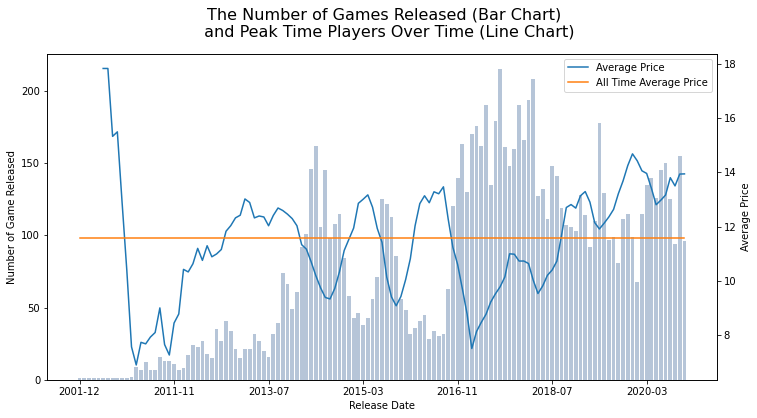

In [13]:
from matplotlib.ticker import MaxNLocator
fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(x=count_df.index, y=count_df["number_of_game_released"],
            color="lightsteelblue", ax=ax1)
ax1.set_ylabel("Number of Game Released")
ax1.set_xlabel("Release Date")
ax2 = ax1.twinx()

sns.lineplot(x=price_df.index.to_series().apply(lambda p: str(p)), 
             y=price_df["price_initial"].rolling(6).mean(),
             legend='brief', 
             label="Average Price", 
             ax=ax2)
sns.lineplot(x=price_df.index.to_series().apply(lambda p: str(p)), 
             y=price_df["price_initial"].mean(), 
             legend='brief', 
             label="All Time Average Price", 
             ax=ax2)
ax2.set_ylabel("Average Price")
ax1.xaxis.set_major_locator(MaxNLocator(nbins=9))

plt.text(65, 19,
         "The Number of Games Released (Bar Chart) \n and Peak Time Players Over Time (Line Chart)",
         horizontalalignment='center',
         fontsize=16)
fig.savefig("timeseries.png")
plt.show()

## Price vs Positive Rating Rates



In [14]:
sub_df = pd.DataFrame(steam_df[["price_initial",
                                "steam_total_positive",
                                "steam_total_negative"]])
sub_df["price_initial"] = sub_df["price_initial"] / 100  # Set the price unit to be dolloar.
sub_df = sub_df.loc[sub_df["price_initial"] <= 60]
sub_df["steam_total_reviews"] = sub_df["steam_total_positive"] + sub_df["steam_total_negative"]

# Filter out games whose total number of reviews are less than 100.
sub_df = sub_df.loc[sub_df["steam_total_reviews"] >= 100]
sub_df["steam_positive_rate"] = steam_df["steam_total_positive"] / sub_df["steam_total_reviews"] * 100

<Figure size 432x288 with 0 Axes>

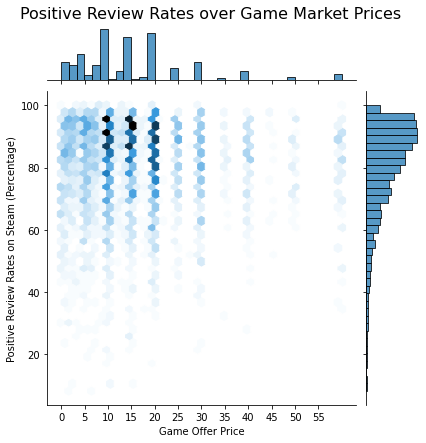

In [15]:
fig = plt.figure()
sns.jointplot(data=sub_df,
              x="price_initial",
              y="steam_positive_rate", 
              kind="hex")
plt.text(32, 128,
         "Positive Review Rates over Game Market Prices",
         horizontalalignment='center',
         fontsize=16)
plt.xticks(ticks=range(0, 60, 5))
plt.xlabel("Game Offer Price")
plt.ylabel("Positive Review Rates on Steam (Percentage)")
plt.savefig("price.png")
plt.show()

## Top Game Developers

In [16]:
sub_df = pd.DataFrame(steam_df[["developers", "steam_total_positive", "steam_total_negative"]])

sub_df["overwhelmingly_postive"] = np.logical_and(
    sub_df["steam_total_positive"] >= 10000,
    sub_df["steam_total_positive"] / (sub_df["steam_total_positive"] + sub_df["steam_total_negative"]) > 0/95)

total_pos_df = sub_df.groupby("developers").agg("sum")

# Extract top 15 developers with highest total positive reviews.
top_developers = total_pos_df.sort_values(
    by=["overwhelmingly_postive", "steam_total_positive"],
    ascending=False
    ).index.to_list()[:15]
top_developers.sort()  # Sort the developers' names in alphabetic order.
total_pos_df = total_pos_df.loc[top_developers]

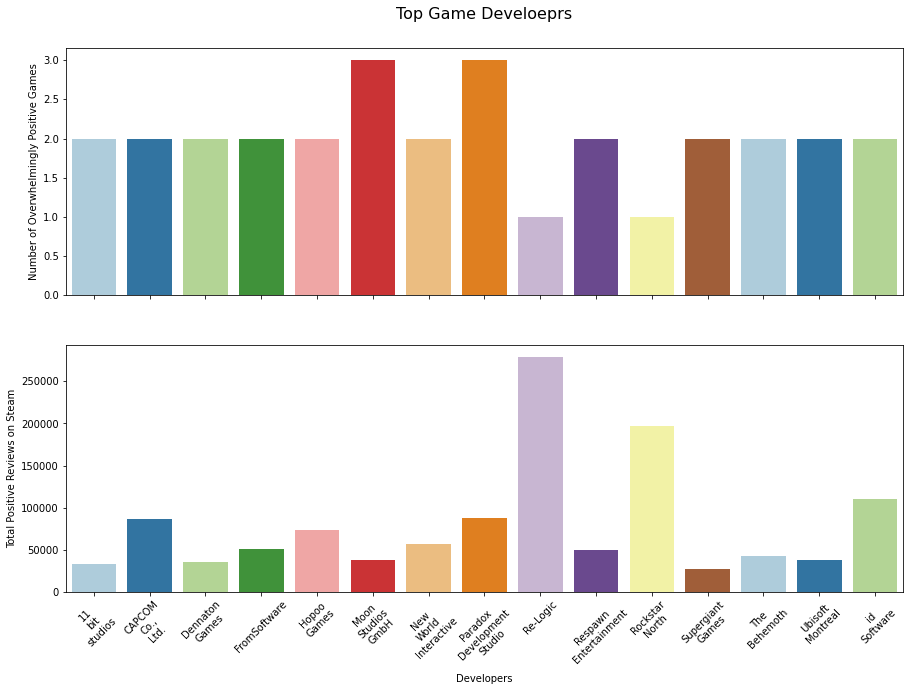

In [17]:
for i in range(len(top_developers)):
    top_developers[i] = top_developers[i].replace(' ', '\n')

fig, axes = plt.subplots(2, sharex=True)
fig.set_figwidth(15)
fig.set_figheight(10)
sns.barplot(x=top_developers, 
            y=total_pos_df["overwhelmingly_postive"],
            palette="Paired",
            ax=axes[0])
sns.barplot(x=top_developers, 
            y=total_pos_df["steam_total_positive"],
            palette="Paired",
            ax=axes[1])
axes[0].set_ylabel("Number of Overwhelmingly Positive Games")
axes[1].set_ylabel("Total Positive Reviews on Steam")
axes[1].set_xlabel("Developers")
axes[1].xaxis.set_tick_params(rotation=45, labelsize=10)
plt.text(7, 680000,
         "Top Game Develoeprs",
         horizontalalignment='center',
         fontsize=16)
fig.savefig("developers.png")
plt.show()

## Top 5 Game Receving Highest Score and Positive Reviews



In [18]:
sub_df = steam_df.sort_values(
    by=["steam_review_score", "steam_total_positive"],
    ascending=False)[:5]
sub_df

,name,steam_review_score,steam_total_positive,steam_total_negative,metacritic,rawg_rating,avg_playtime,price_initial,rawg_genres,rawg_tags,steam_genres,steam_categories,total_recommendations,release_date,short_description,required_age,esrb,recommendation_score,developers,steam_charts_data,all_time_peak_players,rawg_name,rawg_rating_counts,steam_id
10039,Terraria,9.0,279371,5416,83.0,3.99,12.0,999.0,"[{'id': 83, 'name': 'Platformer', 'slug': 'pla...","[{'id': 45, 'name': '2D', 'slug': '2d', 'langu...","Action, Adventure, Indie, RPG","Single-player, Multi-player, PvP, Online PvP, ...",NaN,2011-05-16,"Dig, fight, explore, build! Nothing is impossi...",0,NaN,NaN,Re-Logic,"[{'month-cell left': 'Last 30 Days', 'right nu...",486918.0,Terraria,1364.0,105600
8210,The Witcher 3: Wild Hunt,9.0,130217,3092,92.0,4.68,51.0,3999.0,"[{'id': 3, 'name': 'Adventure', 'slug': 'adven...","[{'id': 40836, 'name': 'Full controller suppor...",RPG,"Single-player, Steam Achievements, Full contro...",NaN,2015-05-18,As war rages on throughout the Northern Realms...,0,NaN,NaN,CD PROJEKT RED,"[{'month-cell left': 'Last 30 Days', 'right nu...",103329.0,The Witcher 3: Wild Hunt,3897.0,292030
357,Phasmophobia,9.0,80487,1635,NaN,3.81,5.0,1399.0,"[{'id': 51, 'name': 'Indie', 'slug': 'indie'},...","[{'id': 40832, 'name': 'Cross-Platform Multipl...","Action, Indie, Early Access","Single-player, Multi-player, Co-op, Online Co-...",NaN,2020-09-18,Phasmophobia is a 4 player online co-op psycho...,0,NaN,NaN,Kinetic Games,"[{'month-cell left': 'Last 30 Days', 'right nu...",112241.0,Phasmophobia,30.0,739630
5590,Undertale,9.0,74825,3035,92.0,4.34,5.0,999.0,"[{'id': 51, 'name': 'Indie', 'slug': 'indie'},...","[{'id': 45, 'name': '2D', 'slug': '2d', 'langu...","Indie, RPG","Single-player, Steam Trading Cards, Remote Pla...",NaN,2015-09-15,UNDERTALE! The RPG game where you don't have t...,0,NaN,NaN,tobyfox,"[{'month-cell left': 'Last 30 Days', 'right nu...",10462.0,Undertale,1061.0,391540
3723,Risk of Rain 2,9.0,59604,1457,85.0,4.10,6.0,2499.0,"[{'id': 2, 'name': 'Shooter', 'slug': 'shooter...","[{'id': 40836, 'name': 'Full controller suppor...","Action, Indie","Single-player, Multi-player, PvP, Online PvP, ...",NaN,2020-08-11,Escape a chaotic alien planet by fighting thro...,0,NaN,NaN,Hopoo Games,"[{'month-cell left': 'Last 30 Days', 'right nu...",71033.0,Risk of Rain 2,274.0,632360
